In [3]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from numpy import linalg
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from validclust import cop

In [4]:
(x_test, y_test), (x_train, y_train) = cifar10.load_data()

In [3]:
x_train.shape

(10000, 32, 32, 3)

In [4]:
x_train.shape[:-1]

(10000, 32, 32)

In [5]:
x_train2 = np.zeros(x_train.shape[:-1],np.float32) #grayscale conversion
for i in range(x_train.shape[0]): 
    x_train2[i]=cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)

In [6]:
x_train2.shape

(10000, 32, 32)

In [7]:
training_data=x_train2/ 255.0 #normalization

In [8]:
training_data = training_data.reshape(len(training_data),-1)
training_data = training_data.reshape(len(training_data),-1)

In [9]:
training_data.shape

(10000, 1024)

In [10]:
pca = PCA(n_components=2)

In [11]:
class kmeans:
    def __init__(self, K, iterations):
        self.K=K
        self.iterations=iterations
    
    def fit(self,X):
        K=self.K
        iterations=self.iterations
        assert(K<=X.shape[0])
#         print(K, iterations)
        Ncentroids=X[0:K,:]  #first K inputs are chosen as centroids for the start
        Edistances = cdist(X, Ncentroids ,'euclidean') #find Euclidean distance
        centroids = self.getCentroidsForInput(Edistances)
        for __ in range(iterations):
            Ncentroids = []
            for idx in range(K):
                __C = X[centroids==idx]
#                 if len(__C)>0:
                __C= __C.mean(axis=0) 
                Ncentroids.append(__C)
            Ncentroids = np.vstack(Ncentroids) #Updated Centroids 
            Edistances = cdist(X, Ncentroids ,'euclidean')
            centroids = self.getCentroidsForInput(Edistances)
        return centroids,Ncentroids

    def getCentroidsForInput(self,Euclidean_distances):
        centroids=[]
        for distance in Euclidean_distances:
            min_dist = np.argmin(distance)
            centroids.append(min_dist)
        return np.asarray(centroids, dtype=np.float32)

In [12]:
model=kmeans(10,50)

In [13]:
x_data=pca.fit_transform(training_data)
labels,centroids = model.fit(x_data)


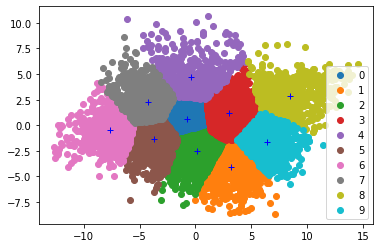

In [14]:
mainLabel = np.asarray(np.unique(labels), dtype=np.int)
for i in mainLabel:
    plt.scatter(x_data[labels == i , 0] , x_data[labels == i , 1] , label = i)
for centroid in centroids:
    plt.plot(centroid[0],centroid[1], 'b+')
plt.legend()
plt.show()

In [15]:
#Average Silhouette Coefficient

In [16]:
score = silhouette_score(x_data, labels)

In [17]:
print(score)

0.32305557


In [18]:
# Dunn's Index

In [19]:
from validclust import cop
from sklearn.metrics import pairwise_distances

In [20]:
dist = pairwise_distances(x_data)

In [21]:
dunn=cop(x_data, dist, labels)

In [22]:
print(dunn)

0.1518355713128612


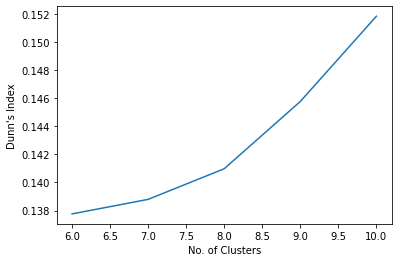

In [23]:
scores=[]
clusters=[]
for k in range(6,11):
    model=kmeans(k,50)
    labels,centroids = model.fit(x_data)
    dunn=cop(x_data, dist, labels)
    scores.append(dunn)
    clusters.append(k)
plt.plot(clusters,scores)
plt.xlabel('No. of Clusters')
plt.ylabel("Dunn's Index")
plt.show()

In [24]:
#Kmeans with autoencoders

In [25]:
from keras import Input, Model,layers
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization


In [26]:
x_test2 = np.zeros(x_test.shape[:-1],np.float32) #grayscale conversion
for i in range(x_test.shape[0]): 
    x_test2[i]=cv2.cvtColor(x_test[i], cv2.COLOR_BGR2GRAY)

In [27]:
train_x_data2= x_test2.reshape(len(x_test2),-1)
train_y_data2=y_test

In [28]:
train_x_data2 = train_x_data2/255 #normalization

In [29]:
train_x_data_norm=x_test/255

In [31]:
train_x_data_norm.shape

(50000, 32, 32, 3)

In [32]:
train_data_noise = train_x_data_norm + 0.1 * np.random.normal(0, 1, size=train_x_data_norm.shape)
train_data_noise = np.clip(train_data_noise, 0., 1.)

In [33]:
train_data_noise.shape

(50000, 32, 32, 3)

In [34]:
input_img = Input(shape=(32, 32, 3))
x = layers.Conv2D(32,kernel_size=3, activation='relu', padding='same')(input_img)
x = BatchNormalization() (x)
x = layers.Conv2D(32,kernel_size=3, strides=2 ,activation='relu', padding='same')(x)
x = layers.Conv2D(32,kernel_size=3, strides=1 ,activation='relu', padding='same')(x)
x = BatchNormalization() (x)
encoded = layers.Conv2D(3,kernel_size=3, strides=1 ,activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32,kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization() (x)
decoded = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(x)

model2 = Model(input_img, decoded)
model2.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:
model2.fit(train_data_noise,train_x_data_norm,epochs=10,batch_size=500)

Epoch 1/10
100/100 [==============================] - 68s 678ms/step - loss: 0.5806
Epoch 2/10
100/100 [==============================] - 68s 678ms/step - loss: 0.5586
Epoch 3/10
100/100 [==============================] - 71s 709ms/step - loss: 0.5563
Epoch 4/10
100/100 [==============================] - 77s 772ms/step - loss: 0.5549
Epoch 5/10
100/100 [==============================] - 77s 771ms/step - loss: 0.5541
Epoch 6/10
100/100 [==============================] - 79s 787ms/step - loss: 0.5536
Epoch 7/10
100/100 [==============================] - 77s 768ms/step - loss: 0.5533
Epoch 8/10
100/100 [==============================] - 76s 760ms/step - loss: 0.5531
Epoch 9/10
100/100 [==============================] - 75s 749ms/step - loss: 0.5530
Epoch 10/10
100/100 [==============================] - 76s 755ms/step - loss: 0.5528


In [36]:
predictions=model2.predict(train_data_noise)

In [37]:
predictions.shape

(50000, 32, 32, 3)

In [38]:
encoder = Model(input_img, encoded)
encoded_data = encoder.predict(train_data_noise)

In [39]:
encoded_data.shape

(50000, 16, 16, 3)

In [40]:
encoded_data = encoded_data.reshape(len(encoded_data),-1)

In [41]:
encoded_data.shape

(50000, 768)

In [42]:
from sklearn.cluster import KMeans

In [43]:
model = KMeans(n_clusters = 10, random_state=1234).fit(encoded_data)

In [44]:
clusters2 = model.predict(encoded_data)

In [45]:
score2 = silhouette_score(encoded_data, clusters2)
print(score2)

0.106988624


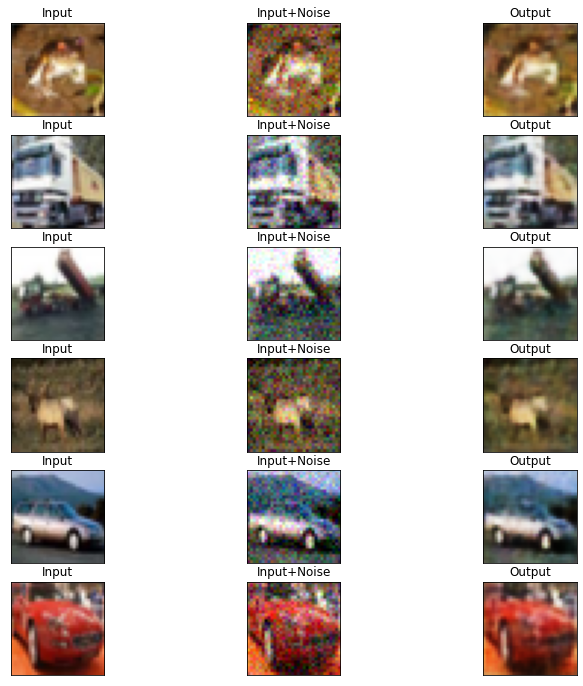

In [46]:
from matplotlib import pyplot
pyplot.figure(figsize=(12,12))
ind=1
for i in range(6):
    pyplot.subplot(6,3,ind)
    pyplot.imshow(train_x_data_norm[i])
    pyplot.title("Input")
    pyplot.xticks([])
    pyplot.yticks([])
    ind=ind+1
    pyplot.subplot(6,3,ind)
    pyplot.imshow(train_data_noise[i])
    pyplot.title("Input+Noise")
    pyplot.xticks([])
    pyplot.yticks([])
    ind=ind+1
    pyplot.subplot(6,3,ind)
    pyplot.imshow(predictions[i])
    pyplot.title("Output")
    pyplot.xticks([])
    pyplot.yticks([])
    ind=ind+1
pyplot.show()